In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader, TensorDataset

from matplotlib import pyplot as plt

import numpy as np
import scipy

2024-12-09 15:02:34.578613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 15:02:34.581959: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 15:02:34.591097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733756554.607122 2351585 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733756554.611912 2351585 cuda_blas.cc:1410] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 15:02:34.628629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
torch.backends.cpu.get_cpu_capability()

'AVX512'

In [6]:
from ml_pws.data.nonlinear_dataset import generate_nonlinear_data

In [13]:
s_trajs, x_trajs = generate_nonlinear_data()
s_trajs

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.1750,  1.6268, -0.0638],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.6093,  0.8495, -1.0772],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.3211,  0.0828,  1.0091],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4381, -0.6691, -0.6751],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5012,  1.2167, -1.2584],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0599, -0.8347,  0.0471]])

Text(0.5, 0, 'lag')

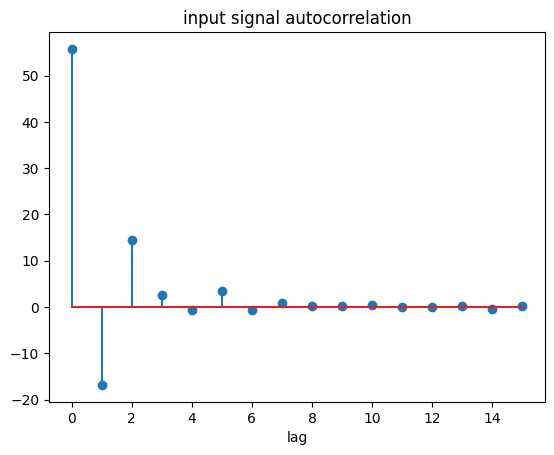

In [5]:
lags = np.arange(-s_trajs.shape[-1]+1, s_trajs.shape[-1])
max_lags = 15
acf = np.mean(np.stack([np.correlate(s, s, mode='full') for s in s_trajs]), axis=0)
pos = np.logical_and(lags >= 0, lags <= max_lags)
plt.stem(lags[pos], acf[pos])
plt.title('input signal autocorrelation')
plt.xlabel('lag')

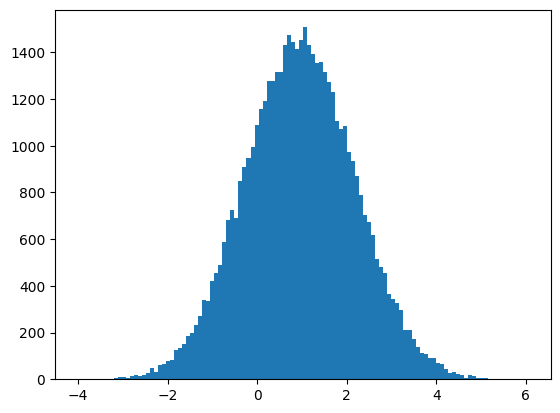

In [6]:
plt.hist(x_trajs.reshape(-1), bins='auto');

# RNN model

## Marginal Model

The `GaussianRNN` is a PyTorch module that models a sequence of data using an RNN architecture and outputs a Gaussian distribution at each time step. Below are the key features:

### Features
- **Input Handling:** 
  - Accepts input sequences of shape `(batch_size, seq_len)`.
  - Preprocesses inputs by shifting them right and setting the first element to zero.
  
- **Architecture:**
  - **RNN Layer:** A vanilla RNN with configurable `input_size`, `hidden_size`, and `num_layers`.
  - **Output Layer:** A linear layer maps RNN outputs to two parameters: the mean and log-variance of the Gaussian distribution at each time step.

- **Outputs:**
  - **Mean and Log-Variance:** Separate outputs for the predicted mean and log-variance of the Gaussian distribution, both with shape `(batch_size, seq_len)`.
  - **Log Probability Calculation (`log_p`):** Computes the log probability of the input sequence given the Gaussian predictions, using the formula:
    $$
    \text{log\_prob} = -\frac{1}{2} \left(\log(2 \pi \sigma^2) + \frac{(x - \mu)^2}{\sigma^2}\right)
    $$
    where $\mu=\text{mean}$ and $\sigma^2 = \exp(\text{log\_var})$.

### Usage
1. Initialize with desired RNN configuration:
   ```python
   model = GaussianRNN(input_size=1, hidden_size=128, num_layers=1)
   ```
2. Forward Pass:
   ```python
   mean, log_var = model(x)  # x is the input sequence
   ```

3. Log Probability:
   ```python
   log_p = model.log_p(x)
   ```


## Conditional Model

The `ConditionalGaussianRNN` is a PyTorch model designed for probabilistic sequence modeling of the conditional distribution $P(x|s)$. It extends the `GaussianRNN` by incorporating an additional conditional input $s$ into the sequence modeling process.

## Features

- **Conditioning Input $s$:**
  - $s$ is a context variable with shape `(batch_size, seq_len)`, representing external information that conditions the distribution of $x$.

- **Input Handling:**
  - The model takes two inputs:
    - \( s \): The conditioning sequence.
    - \( x \): The target sequence whose conditional distribution is modeled.
  - The input \( x \) is shifted right, with the first element set to zero, to mimic autoregressive behavior.

- **Architecture:**
  - **RNN Layer:** Takes a concatenated input of $s$ and the shifted $x$ along the feature dimension, allowing the model to condition the sequence distribution on $s$.
  - **Output Layer:** Outputs the mean and log-variance of the Gaussian distribution for each time step.

- **Outputs:**
  - **Mean and Log-Variance:** Predicted mean and log-variance of the conditional Gaussian distribution \( P(x|s) \), both with shape `(batch_size, seq_len)`.
  - **Log Probability Calculation (`log_p`):** Computes the log probability of the target sequence \( x \) conditioned on \( s \), using:
    $$
    \text{log\_prob} = -\frac{1}{2} \left(\log(2 \pi \text{var}) + \frac{(x - \text{mean})^2}{\text{var}}\right)
    $$
    where $\text{var} = e^{\text{log\_var}}$.

In [7]:
from ml_pws.models.doe_estimator import DoeEstimator

doe_estimator = DoeEstimator(1, 64, 2)
doe_estimator

DoeEstimator(
  (conditional_model): ConditionalGaussianRNN(
    (rnn): RNN(2, 64, num_layers=2, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=2, bias=True)
  )
  (marginal_model): GaussianRNN(
    (rnn): RNN(1, 64, num_layers=2, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [8]:
# train_loader = generate_nonlinear_data()

# trainer = L.Trainer(max_epochs=50)
# trainer.fit(model=doe_estimator, train_dataloaders=train_loader)

tensor(3.8984)

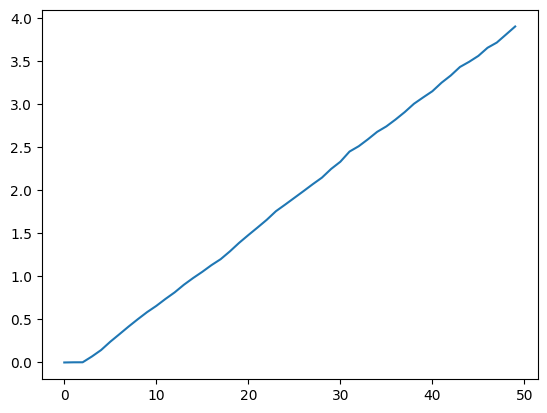

In [9]:
model = DoeEstimator.load_from_checkpoint("lightning_logs/version_3/checkpoints/epoch=49-step=1000.ckpt")
mi = model.estimate_mutual_information(s_trajs, x_trajs)
plt.plot(mi.mean(0).cumsum(0))
mi.mean(0).sum(0)

# Contrastive Learning (InfoNCE)

In [7]:
from ml_pws.models.contrastive_mi import ContrastiveEstimator

contrastive_estimator = ContrastiveEstimator(1, 64, 2)
contrastive_estimator

ContrastiveEstimator(
  (score_fn): ScoringFunction(
    (conv_layers): Sequential(
      (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [8]:
train_loader = DataLoader(TensorDataset(*generate_nonlinear_data()), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(*generate_nonlinear_data(seed=40)), batch_size=32)

trainer = L.Trainer(max_epochs=50)
trainer.fit(model=contrastive_estimator, train_dataloaders=train_loader, val_dataloaders=val_loader)

/home/reinhardt/ml-pws/ml_pws/data/nonlinear_dataset.py:142: RuntimeWarning: overflow encountered in exp
  bias = 1 / (1 + np.exp(-s_cur * self.gain))
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | score_fn | ScoringFunction | 12.9 K | train
-----------------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 32/32 [00:02<00:00, 12.34it/s, v_num=6]


In [20]:
val_data = generate_nonlinear_data(seed=3)
model = ContrastiveEstimator.load_from_checkpoint("lightning_logs/version_6/checkpoints/epoch=49-step=1600.ckpt")
with torch.no_grad():
    mi = np.log(val_data[0].size(0)) - model(*val_data)
mi

tensor(3.3068)

# MINE

In [14]:
class MineNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int=1, kernel_size: int = 3):
        super().__init__()
        self.num_layers = num_layers

        # Build convolutional layers
        layers = []
        for i in range(num_layers):
            in_channels = input_size if i == 0 else hidden_size
            layers.append(nn.Conv1d(in_channels, hidden_size, kernel_size, padding=kernel_size // 2))
            layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*layers)

        # Final linear layer to output a scalar
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass through the network.
        
        Args:
        - x: Input tensor of shape (batch_size, seq_len, num_features).

        Returns:
        - Output tensor of shape (batch_size,).
        """
        # Permute input to match Conv1D expectations: (batch_size, num_features, seq_len)
        x = x.permute(0, 2, 1)

        # Pass through convolutional layers
        x = self.conv_layers(x)  # (batch_size, hidden_size, seq_len)

        # Aggregate features by global average pooling
        x = x.mean(dim=2)  # (batch_size, hidden_size)

        # Final linear layer
        x = self.output_layer(x).squeeze(-1)  # (batch_size,)
        return x

In [16]:
class MINE:
    def __init__(self, input_size, hidden_size, num_layers=4, kernel_size=10, lr=1e-3):
        self.net = MineNetwork(input_size, hidden_size, num_layers=num_layers, kernel_size=kernel_size)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def train_step(self, joint_samples, marginal_samples):
        joint_preds = self.net(joint_samples)
        marginal_preds = self.net(marginal_samples)

        mi_estimate = torch.mean(joint_preds, dim=0) - torch.logsumexp(marginal_preds, dim=0)

        # Negate to create a loss function (maximize MI estimate)
        loss = -mi_estimate.mean()

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def estimate_mutual_information(self, joint_samples, marginal_samples):
        """
        Estimate mutual information using the current network.
        """
        with torch.no_grad():
            joint_preds = self.net(joint_samples)
            marginal_preds = self.net(marginal_samples)

            # Compute the mutual information lower bound
            N = torch.tensor(marginal_preds.size(0), dtype=torch.float32)
            mi_estimate = torch.mean(joint_preds, dim=0) - torch.logsumexp(marginal_preds, dim=0) + torch.log(N)

        return mi_estimate

In [19]:
mine = MINE(2, 64, 4)

writer = SummaryWriter('../metrics/MINE_conv')

num_epochs = 500

s = ar_model.sample(torch.zeros(1000, 3), 100)
x = torch.tensor(x_model.sample(s_trajs.numpy(), seed=3))
x_marginal = torch.tensor(x_model.sample(ar_model.sample(torch.zeros(1000, 3), 100).numpy(), seed=4))

batch_size=128
joint_loader = DataLoader(TensorDataset(s, x), batch_size=batch_size, shuffle=True)
marginal_loader = DataLoader(TensorDataset(s, x_marginal), batch_size=batch_size, shuffle=True)


# training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for (joint_samples, marginal_samples) in zip(joint_loader, marginal_loader):
        joint_samples = torch.stack(joint_samples, dim=-1)
        marg_samples = torch.stack(marginal_samples, dim=-1)
        loss = mine.train_step(joint_samples, marg_samples)

    writer.add_scalar("loss", loss, epoch)

writer.close()

In [20]:
mine.estimate_mutual_information(torch.stack([s, x], dim=-1), torch.stack([s, x_marginal], dim=-1))

tensor(97083.5312)